In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# install spark in google colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
# !ls
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install spark_sklearn
!pip install pyspark

     |████████████████████████████████| 4.9MB 15.9MB/s 
  Created wheel for spark-sklearn: filename=spark_sklearn-0.3.0-cp36-none-any.whl size=30592 sha256=4803b616fd690f4fac47b8df08ae1c9ecb022f4b646c5c265f27ed86c2c9c82e
  Stored in directory: /root/.cache/pip/wheels/64/28/e8/cb0250888675c630786f932dcc63ed96ac1aca299bcfb7235f
Successfully built spark-sklearn
ERROR: yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
ERROR: imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
     |████████████████████████████████| 215.7MB 64kB/s 
     |████████████████████████████████| 204kB 50.8MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=7270b0fdf7dca4c5d88f7bde08239b4be282a22ee5b834a

In [0]:
# set up spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
# library

import time
from scipy import stats
import pyspark
from pyspark import SparkContext, SparkConf
sc = pyspark.SparkContext()
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [0]:
#load dataset
def get_data():
    #get train data
    train_data_path ='/content/drive/My Drive/csl data case analytics/code/final_synthesis(KNN)_train.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='/content/drive/My Drive/csl data case analytics/code/final_synthesis(KNN)_test.csv'
    test = pd.read_csv(test_data_path)
    
    return train , test

def get_combined_data():
    #reading train data
    train , test = get_data()
    # Feature Scaling for numerical attributes only
    from sklearn import preprocessing
    min_max_scaler = preprocessing.MinMaxScaler()
    train.iloc[:, 1:3] = min_max_scaler.fit_transform(train.iloc[:, 1:3])
    train.iloc[:, 5:] = min_max_scaler.fit_transform(train.iloc[:, 5:])
    test.iloc[:,1:3] = min_max_scaler.fit_transform(test.iloc[:, 1:3])
    test.iloc[:,5:] = min_max_scaler.fit_transform(test.iloc[:,5:])
    train = np.around(train, decimals=2)
    test = np.around(test, decimals=2)
    # target = train.rating
    
    # train.drop(['rating'],axis = 1 , inplace = True)
    
    target = train.price
    
    train.drop(['price'],axis = 1 , inplace = True)

    
    combined = train.append(test,sort=False)
    
    combined.reset_index(inplace=True)
    
    combined.drop(['index','price'], inplace=True, axis=1)
    
    return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [0]:
#combined.describe()

combined.head()

name  launch_date  ... Battery Capacity rating
0  Samsung Galaxy A50s (6+128GB)         0.47  ...             0.22   1.00
1       HUAWEI Nova 5T (8+128GB)         0.00  ...             0.20   0.72
2        Sony Xperia 5 (6+128GB)         0.00  ...             0.15   0.38
3   Xiaomi 小米 9 Pro 5G (8+256GB)         0.00  ...             0.22   0.62
4    HUAWEI Nova 5 Pro (8+128GB)         0.01  ...             0.18   0.66

[5 rows x 14 columns]

In [0]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [0]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 11
Number of nun-numerical columns with no nan values : 3


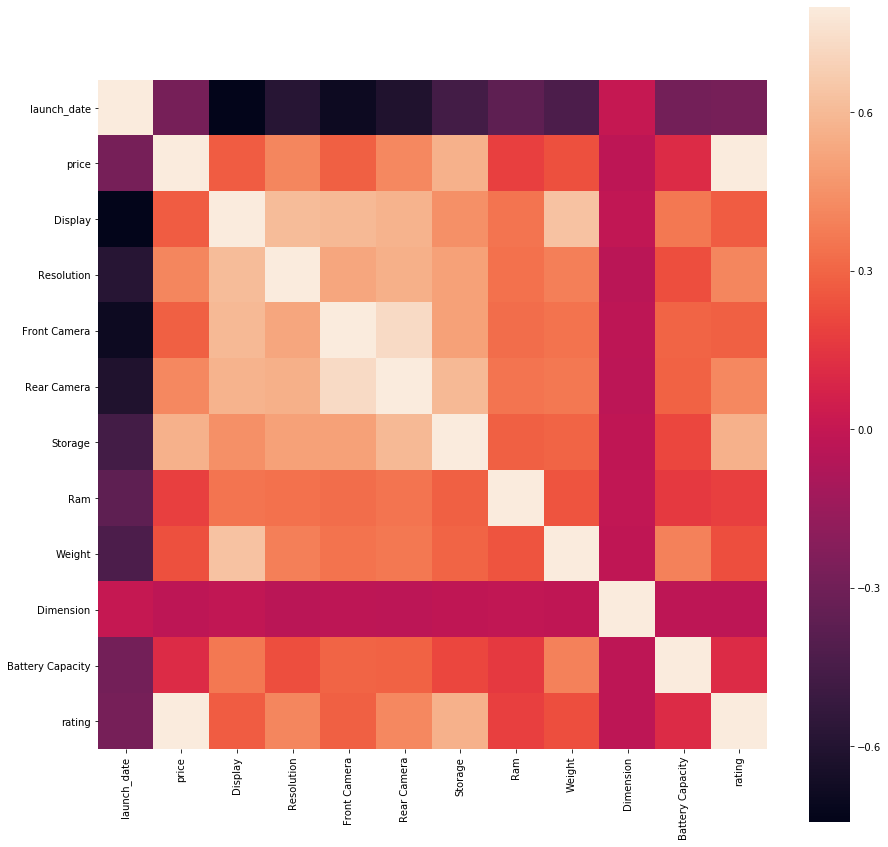

In [0]:
# Correlation Heatmap (Attributes with continuous values)
train_data = train_data
train_data['rating'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()
#print(C_mat)

In [0]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 14 columns before encoding categorical features
There are 3405 columns after encoding categorical features


In [0]:
def split_combined():
    global combined
    train = combined[:2764]
    test = combined[2764:]

    return train , test 
  
train, test = split_combined()

In [0]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               435968    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 600,833
Trainable params: 600,833
Non-trainable params: 0
_________________________________________________________________


In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [0]:
history = NN_model.fit(train, target, epochs=3000, batch_size=16, validation_split = 0.2, callbacks=callbacks_list)





Train on 2211 samples, validate on 553 samples
Epoch 1/3000





2211/2211 [==============================] - 2s 875us/step - loss: 0.0471 - mean_absolute_error: 0.0471 - val_loss: 0.0193 - val_mean_absolute_error: 0.0193

Epoch 00001: val_loss improved from inf to 0.01926, saving model to Weights-001--0.01926.hdf5
Epoch 2/3000
2211/2211 [==============================] - 1s 557us/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228

Epoch 00002: val_loss did not improve from 0.01926
Epoch 3/3000
2211/2211 [==============================] - 1s 569us/step - loss: 0.0274 - mean_absolute_error: 0.0274 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213

Epoch 00003: val_loss did not improve from 0.01926
Epoch 4/3000
2211/2211 [==============================] - 1s 573us/step - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0270 - val_mean_absolute_error: 0.0270

Epoch 00004: val_loss did not improve from 0.01926
Epoch 5/3000
2

In [0]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()